In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization import determine_r_max
from decimation_staggered import (
required_initial_max_distance, right_pos_staggered, r_max,
_all_spins, plus_configs, minus_configs, intracell_energies, log_Rpp_Rpm)
from utils import logsumexp, _xorshift64star_next, _u01_from_uint64

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numba import njit


@njit(cache=True)
def extract_p(J):
    n_neg = 0
    for r in range(len(J)):
        if J[r] < 0.0:
            n_neg += 1
    p = n_neg / len(J)  # in [0,1]
    return p

@njit(cache=True)
def generate_signs(D, p, seed):
    """
    Generate bond signs with an EXACT fraction p of -1 bonds.
    Total number of distances = D.
    Exactly floor(p*D) entries are -1, the rest +1, randomly permuted.
    """
    signs = np.empty(D + 1, dtype=np.int8)
    signs[0] = 0  # unused

    # number of negative bonds
    n_minus = int(p * D)
    n_plus  = D - n_minus

    # fill deterministically
    idx = 1
    for _ in range(n_minus):
        signs[idx] = -1
        idx += 1
    for _ in range(n_plus):
        signs[idx] = 1
        idx += 1

    # --- Fisher–Yates shuffle (Numba-safe) ---
    state = np.uint64(seed) ^ np.uint64(0x9E3779B97F4A7C15)
    if state == np.uint64(0):
        state = np.uint64(0xD1B54A32D192ED03)

    for i in range(D, 1, -1):
        state, rnd = _xorshift64star_next(state)
        j = 1 + (rnd % np.uint64(i))  # j in [1, i]
        tmp = signs[i]
        signs[i] = signs[j]
        signs[j] = tmp

    return signs

# Build signed long-range couplings J_r = sign[r] * J0 / r^a
@njit(cache=True)
def build_J_random(J0, a, D, p, seed):
    """
    Returns J[0..D], with random signs controlled by p.
    """
    signs = generate_signs(D, p, seed)
    J = np.zeros(D + 1, dtype=np.float64)
    for r in range(1, D + 1):
        J[r] = (J0 * signs[r]) / (r ** a)
    return J

# ----------------------------
# One RG step (staggered, signed couplings)
# ----------------------------

@njit(cache=True)
def rg_step(J, a, seed=None, fixed_size=False):

    D = len(J) - 1
    rstop = determine_r_max(D)

    if fixed_size:
        
        # Allocate fixed-length output (same D)
        J_new = np.zeros_like(J)
        J_new[0] = 0.0
    
        # Head: exact renormalization
        for r in range(1, rstop + 1):
            log_pp, log_pm = log_Rpp_Rpm(r, J)
            J_new[r] = 0.5 * (log_pp - log_pm)
    
        # Re-estimate p_k from the head (fraction of negative couplings)
        p_k = extract_p(J_new[1:rstop + 1])
        
        # Tail: power-law continuation with fraction p_k of negative signs
        Ntail = D - rstop
        # anchor magnitude (use abs so the tail sign is controlled only by generated signs)
        anchor = abs(J_new[rstop])
    
        # build tail sign array with exact ratio floor(p_k * Ntail) negatives, then shuffle
        n_minus = int(p_k * Ntail)
        # tail_signs indexed 0..Ntail-1 corresponding to r=rstop+1..D
        tail_signs = np.empty(Ntail, dtype=np.int8)
        for i in range(n_minus):
            tail_signs[i] = -1
        for i in range(n_minus, Ntail):
            tail_signs[i] = 1
    
        # Fisher–Yates shuffle (Numba-safe) using provided xorshift64* PRNG
        state = np.uint64(seed) ^ np.uint64(0x9E3779B97F4A7C15) ^ np.uint64(rstop)
        if state == np.uint64(0):
            state = np.uint64(0xD1B54A32D192ED03)
    
        for i in range(Ntail - 1, 0, -1):
            state, rnd = _xorshift64star_next(state)
            j = int(rnd % np.uint64(i + 1))  # j in [0, i]
            tmp = tail_signs[i]
            tail_signs[i] = tail_signs[j]
            tail_signs[j] = tmp
    
        # write tail couplings
        for t in range(Ntail):
            r = rstop + 1 + t
            J_new[r] = (tail_signs[t] * anchor) * (rstop / r) ** a

    else:
        J_new = np.zeros(rstop + 1, dtype=np.float64)
    
        for r in range(1, rstop + 1):
            log_pp, log_pm = log_Rpp_Rpm(r, J)
            J_new[r] = 0.5 * (log_pp - log_pm)

    return J_new

# ----------------------------
# RG flow generator (random signs controlled by p)
# ----------------------------

def generate_rg_flow_random_signs(J0, a, D, n_steps, p, seed=12345, fixed_size=False):
    """
    Creates initial signed power-law couplings with AF fraction p,
    then iterates RG steps deterministically (no re-randomization each step).
    """
    J = build_J_random(J0, a, D, p, seed)
    flow = [J.copy()]
    for _ in range(n_steps):
        J = rg_step(J, a, seed, fixed_size)
        flow.append(J.copy())
    return flow

def plot_rg_flow(flow, distances_to_plot=None):
    n_steps_plus_1 = len(flow)
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = [1, 2, 3, 4, 5]

    plt.figure(figsize=(7, 5))
    for r in distances_to_plot:
        # Some later RG steps shrink D, so skip if r out of range at a given step.
        vals = []
        valid_steps = []
        for k, J in enumerate(flow):
            if 1 <= r <= (len(J) - 1):
                vals.append(J[r])
                valid_steps.append(k)
        if len(vals) > 0:
            plt.plot(np.array(valid_steps), np.array(vals), marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling $J_r$")
    plt.legend()
    plt.tight_layout()
    plt.show()


def determine_phase_sink(
    J0, a, max_dist_final, n_steps_total,
    p=0.0, seed=19,
    track_r=(2,),
    eval_step=None,
    thr_dis=1e-2,
    thr_ord=1e2,
    fixed_size=False,
):
    """
    Determine the RG phase sink from the signed-coupling staggered RG flow.

    Decision rule (evaluated at a chosen RG step):
      - Disorder:  |J_r| < thr_dis  for all r in track_r
      - Ferro:     |J_r| > thr_ord  for all r in track_r AND J_r > 0 for all
      - Antiferro: |J_r| > thr_ord  for all r in track_r AND J_r < 0 for all

    Parameters
    ----------
    max_dist_final : int
        Desired final cutoff after n_steps_total (used to compute required initial D0).
    n_steps_total : int
        Total RG steps to generate.
    eval_step : int or None
        Step at which to evaluate sink. If None, uses the last step (n_steps_total).

    Returns
    -------
    phase : str
        "disorder", "ferro", "antiferro", or "undetermined".
    info : dict
        Diagnostic details (step used, tracked couplings, etc.).
    """
    # initial cutoff large enough so that after n_steps_total we still have max_dist_final
    D0 = required_initial_max_distance(max_dist_final, n_steps_total)

    # generate signed initial condition and RG flow
    flow = generate_rg_flow_random_signs(J0=J0, a=a, D=D0, n_steps=n_steps_total, p=p, seed=seed, fixed_size=fixed_size)

    if eval_step is None:
        eval_step = n_steps_total
    if eval_step < 0:
        eval_step = 0
    if eval_step > n_steps_total:
        eval_step = n_steps_total

    J_eval = flow[eval_step]
    D_eval = len(J_eval) - 1

    # collect tracked couplings (must exist at eval step)
    tracked = {}
    missing = []
    for r in track_r:
        if 1 <= r <= D_eval:
            tracked[int(r)] = float(J_eval[r])
        else:
            missing.append(int(r))

    # if any requested distance is not available at the evaluation step, declare undetermined
    if len(missing) > 0:
        return "undetermined", {
            "reason": "missing_tracked_distances_at_eval_step",
            "eval_step": int(eval_step),
            "D_eval": int(D_eval),
            "missing_r": missing,
            "tracked": tracked,
        }

    vals = np.array([tracked[int(r)] for r in track_r], dtype=np.float64)
    abs_vals = np.abs(vals)

    # Disorder
    if np.all(abs_vals < thr_dis):
        return "disorder", {
            "eval_step": int(eval_step),
            "tracked": tracked,
            "criterion": f"all |J_r| < {thr_dis}",
        }

    # Ferro / Antiferro
    if np.all(abs_vals > thr_ord):
        if np.all(vals > 0.0):
            return "ferro", {
                "eval_step": int(eval_step),
                "tracked": tracked,
                "criterion": f"all |J_r| > {thr_ord} and all J_r > 0",
            }
        if np.all(vals < 0.0):
            return "antiferro", {
                "eval_step": int(eval_step),
                "tracked": tracked,
                "criterion": f"all |J_r| > {thr_ord} and all J_r < 0",
            }

    return "undetermined", {
        "eval_step": int(eval_step),
        "tracked": tracked,
        "criterion": "did not meet disorder/ferro/antiferro thresholds coherently",
        "thr_dis": float(thr_dis),
        "thr_ord": float(thr_ord),
    }


def scan_phase_sinks_p_T(
    p_values,
    T_values,
    a,
    max_dist_final,
    n_steps_total,
    track_r=(2, 3, 4, 5),
    eval_step=None,
    seed=12345,
    thr_dis=1e-2,
    thr_ord=1e2,
    fixed_size=False
):
    """
    Scan (p, T) grid, classify phase sink at each point, and return 4 arrays of points:
      - disorder_points:     shape (Nd, 2) columns [p, T]
      - ferro_points:        shape (Nf, 2) columns [p, T]
      - antiferro_points:    shape (Na, 2) columns [p, T]
      - undetermined_points: shape (Nu, 2) columns [p, T]
    """
    p_values = np.asarray(p_values, dtype=np.float64)
    T_values = np.asarray(T_values, dtype=np.float64)

    disorder_pts = []
    ferro_pts = []
    antiferro_pts = []
    undet_pts = []

    for p in p_values:
        for T in T_values:
            J0 = 1.0 / float(T)

            phase, _info = determine_phase_sink(
                J0=J0,
                a=a,
                max_dist_final=max_dist_final,
                n_steps_total=n_steps_total,
                p=float(p),
                seed=int(seed),
                track_r=track_r,
                eval_step=eval_step,
                thr_dis=thr_dis,
                thr_ord=thr_ord,
                fixed_size=fixed_size,
            )

            if phase == "disorder":
                disorder_pts.append((p, T))
            elif phase == "ferro":
                ferro_pts.append((p, T))
            elif phase == "antiferro":
                antiferro_pts.append((p, T))
            else:
                undet_pts.append((p, T))

    disorder_points = np.array(disorder_pts, dtype=np.float64).reshape((-1, 2))
    ferro_points = np.array(ferro_pts, dtype=np.float64).reshape((-1, 2))
    antiferro_points = np.array(antiferro_pts, dtype=np.float64).reshape((-1, 2))
    undetermined_points = np.array(undet_pts, dtype=np.float64).reshape((-1, 2))

    return disorder_points, ferro_points, antiferro_points, undetermined_points


def plot_phase_points_p_T(
    disorder_points,
    ferro_points,
    antiferro_points,
    undetermined_points,
    title="Phase sinks in (p, T) plane",
    marker_size=12,
):
    """
    Scatter plot of phase points in p vs T=1/J plane.
    Uses square markers ('s') with fixed colors per phase.
    """
    plt.figure(figsize=(7.5, 5.5))

    if disorder_points.size:
        plt.scatter(disorder_points[:, 0], disorder_points[:, 1],
                    s=marker_size, marker='s', c='tab:gray', label='Disorder')
    if ferro_points.size:
        plt.scatter(ferro_points[:, 0], ferro_points[:, 1],
                    s=marker_size, marker='s', c='tab:blue', label='Ferro')
    if antiferro_points.size:
        plt.scatter(antiferro_points[:, 0], antiferro_points[:, 1],
                    s=marker_size, marker='s', c='tab:red', label='Antiferro')
    if undetermined_points.size:
        plt.scatter(undetermined_points[:, 0], undetermined_points[:, 1],
                    s=marker_size, marker='s', c='tab:orange', label='Undetermined')

    plt.xlabel("Antiferromagnetic bond concentration p")
    plt.ylabel("Temperature 1/J")
    plt.title(title)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

# RG flow

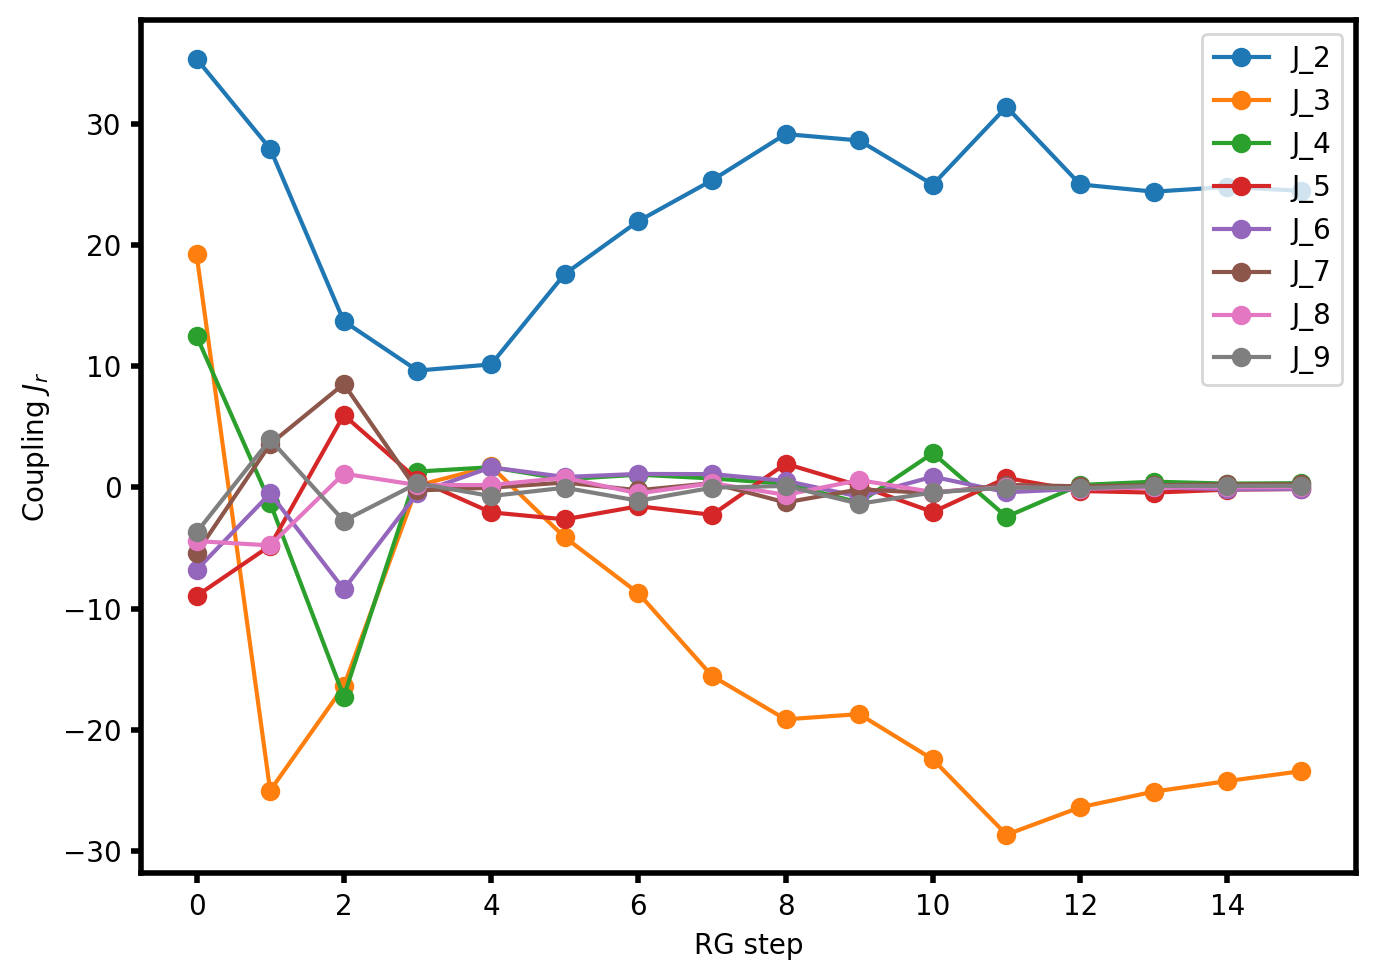

In [8]:
D0 = required_initial_max_distance(max_dist_final=6, n_steps=10)

flow = generate_rg_flow_random_signs(J0=100, a=1.5, D=1000000, n_steps=15, p=0.5,
                                     seed=2, fixed_size=True)
plot_rg_flow(flow, distances_to_plot=[2,3,4,5,6,7,8,9])

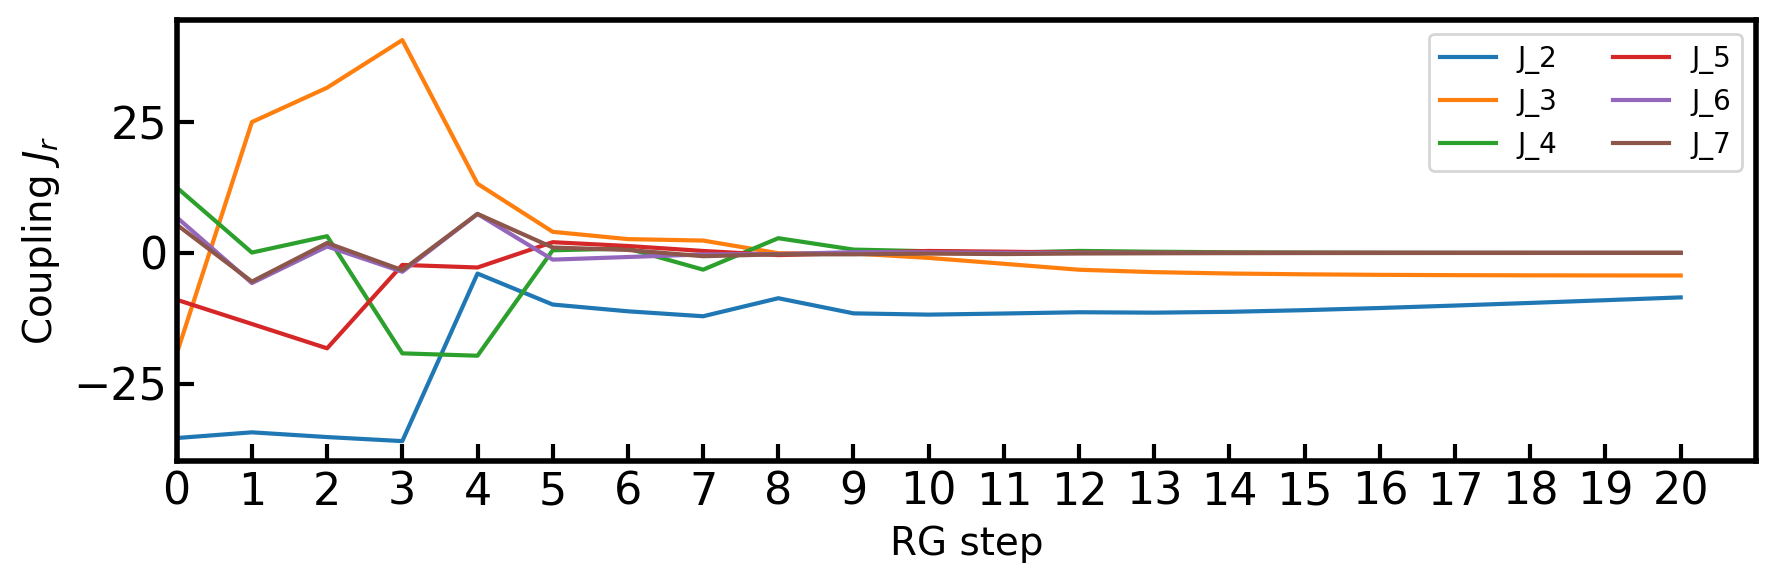

In [5]:
plt.rcParams['axes.linewidth'] = 2  # Axis line width
plt.rcParams['xtick.major.width'] = 2  # X-tick line width
plt.rcParams['ytick.major.width'] = 2  # Y-tick line width

steps = np.arange(len(flow))
distances_to_plot = [2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize=(9, 3))
for r in distances_to_plot:
    vals = []
    valid_steps = []
    for k, J in enumerate(flow):
        if 1 <= r <= (len(J) - 1):
            vals.append(J[r])
            valid_steps.append(k)
    if len(vals) > 0:
        plt.plot(np.array(valid_steps), np.array(vals), marker='', label=f"J_{r}")

plt.xlim(0, None)
#plt.ylim(-100, 100)

plt.xticks(steps)
plt.tick_params(axis='both', which='major', labelsize=16, width=1.5, length=6, direction='in')
plt.legend(ncol=2, fontsize=12, borderpad=.3, labelspacing=.2, handlelength=1.3, handletextpad=.3, columnspacing=.8)

plt.xlabel("RG step", fontsize=14)
plt.ylabel("Coupling $J_r$", fontsize=14)
plt.legend(ncols=2)
plt.tight_layout()
#plt.savefig(f'../figures/chaos.png')
plt.show()

# Phase diagram

In [25]:
determine_phase_sink(
    J0=100, a=1.5, max_dist_final=6, n_steps_total=9,
    p=0.5, track_r=(2,), fixed_size=True)

('undetermined',
 {'eval_step': 9,
  'tracked': {2: -0.012210035435743727},
  'criterion': 'did not meet disorder/ferro/antiferro thresholds coherently',
  'thr_dis': 0.01,
  'thr_ord': 100.0})

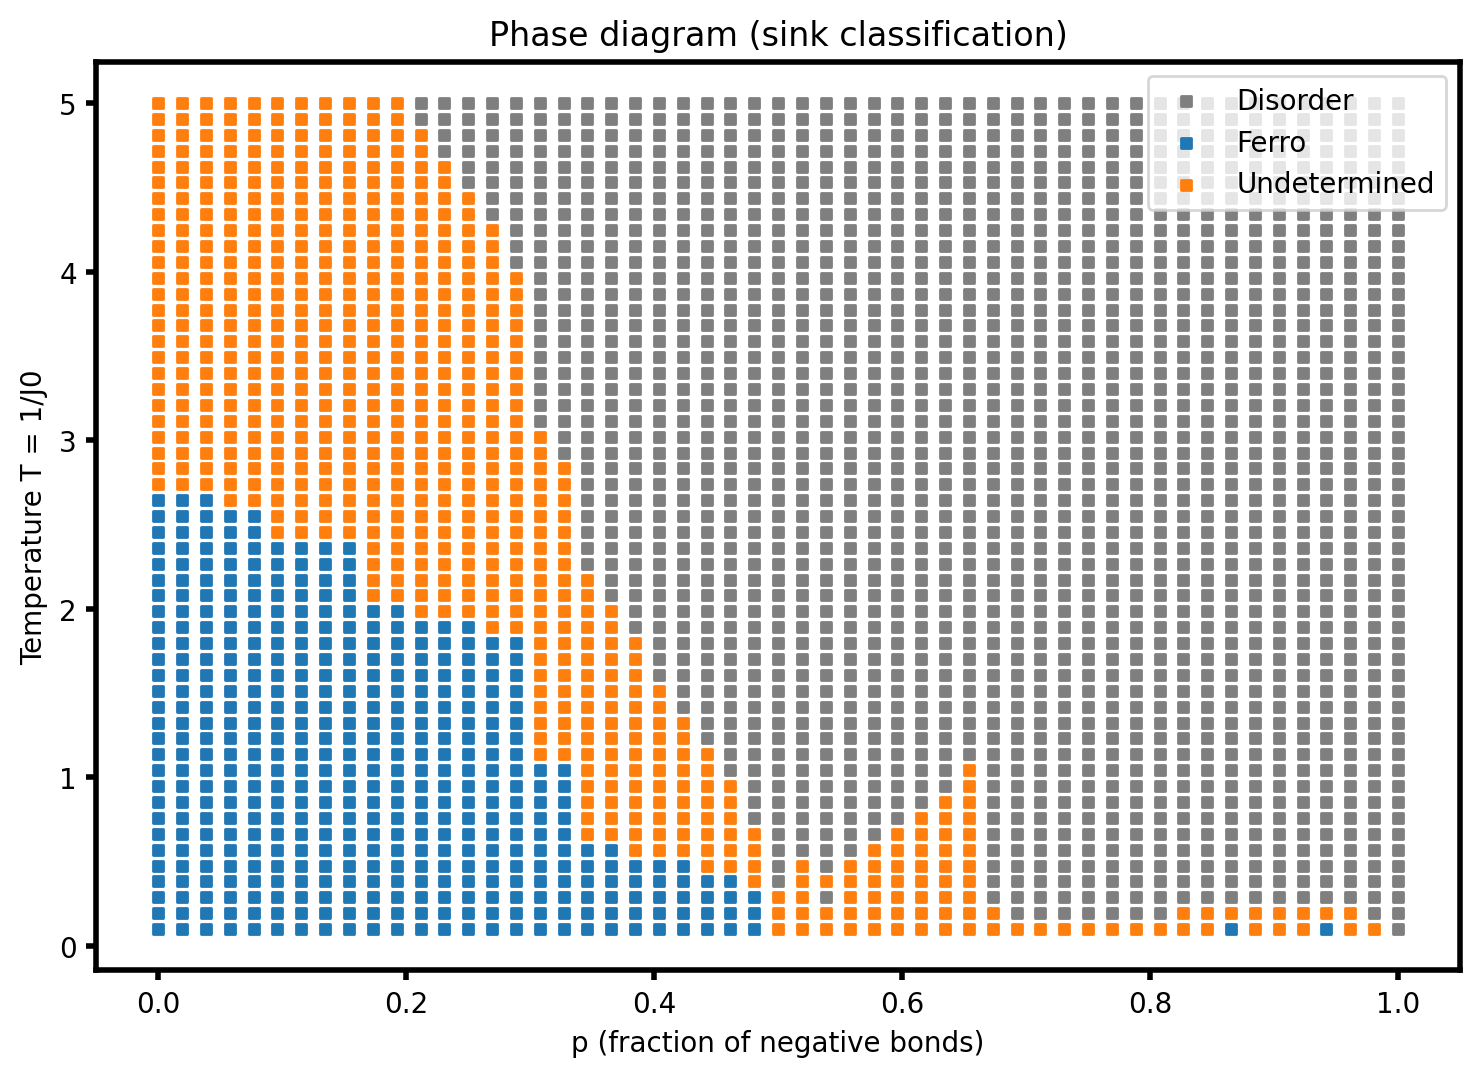

In [26]:
p_vals = np.linspace(0.0, 1, 53)
T_vals = np.linspace(0.1, 5, 53)

dis, fer, anti, und = scan_phase_sinks_p_T(
    p_values=p_vals,
    T_values=T_vals,
    a=1,
    max_dist_final=6,
    n_steps_total=10,
    track_r=(2,3),
    eval_step=None,
    seed=19,
    fixed_size=True
)
plot_phase_points_p_T(dis, fer, anti, und, title="Phase diagram (sink classification)")